In [16]:
%matplotlib notebook
from mpl_toolkits import mplot3d


import numpy as np
import matplotlib.pyplot as plt
import pybullet as p
import pybullet_data 
import time
import math
import random
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F

In [17]:
physicsClient = p.connect(p.GUI)

In [18]:
p.setGravity(0,0,-10) 
p.resetSimulation() 
p.setAdditionalSearchPath(pybullet_data.getDataPath()) 
planeId = p.loadURDF("plane.urdf") 
robotId = p.loadURDF("Summer/summer_project/kuka_iiwa/urdf/iiwa7.urdf",flags=9, useFixedBase=1)

robotStartPos = [0,0,0]
robotStartOrientation = p.getQuaternionFromEuler([0,0,0])

p.resetBasePositionAndOrientation(robotId,robotStartPos,robotStartOrientation)

p.setJointMotorControlArray(robotId,range(7),p.VELOCITY_CONTROL,forces=np.zeros(7))

In [19]:
def simulate_system(x, u):
    x_next=[]
    for i in range(7):
        p.resetJointState(robotId,i,x[i],targetVelocity = x[i+7])
    
    p.setJointMotorControlArray(robotId,range(7), controlMode=p.TORQUE_CONTROL,forces=u)
    p.stepSimulation()
    for i in range(7):
        x_next.append(p.getJointStates(robotId,range(7))[i][0])
    for i in range(7):
        x_next.append(p.getJointStates(robotId,range(7))[i][1])
    x_next = np.array(x_next)
    return x_next

In [20]:
N=3000
x = np.zeros([14,N])
u= np.zeros([7, N])
x_new=np.zeros([14,N])
for i in range(N):
    for j in range(7):
        a=random.randint(-180,180)#angule range(-pi,pi)
        b=random.uniform(-10, 10)#velocity range
        c=random.randint(-30,30)#torque range (-200,200)
        x[j,i]=math.radians(a/math.pi)
        x[j+7,i]=b
        u[j,i]=c
# print(x)
# print(u)
for i in range(N):
    x_new[:,i]=simulate_system(x[:,i], u[:,i])
# print("new state is:", x_new)

In [21]:
x=x.T
u = u.T
x_train = np.append(x,u,axis=1)
#print(np.shape(x_train))
y_train = x_new.T
#print(y_train)
x_train = x_train.astype(np.float32)
y_train = y_train.astype(np.float32)
x_train = torch.from_numpy(x_train)
y_train = torch.from_numpy(y_train)

In [23]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(21, 50),
            nn.ReLU(),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Linear(50, 14),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(21, 500)   # hidden layer
        self.predict = torch.nn.Linear(500, 14)   # output layer

    def forward(self, x):
        x = F.relu(self.hidden(x))      # activation function for hidden layer
        x = self.predict(x)             # linear output
        return x


class MultiLinearRegression(nn.Module):
    def __init__(self):
        super(MultiLinearRegression, self).__init__()
        self.linear = nn.Linear(21,14)  
    def forward(self,x):
        out = self.linear(x)
        return out

model = Net()

criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=1e-3)

floss=[]
elist=[]
gradlist=[]
epoch = 0
while True:
    output = model(x_train)  
    loss = criterion(output, y_train)  
    loss_value = loss.data.cpu().numpy() 
    optimizer.zero_grad()  
    loss.backward()

    total_norm=0
    for k in model.parameters():
        param_norm = k.grad.data.norm(2)
        total_norm += param_norm.item() ** 2
    total_norm = total_norm ** (1. / 2)
    gradlist.append(total_norm)
    optimizer.step() 
    
    epoch += 1
    if epoch % 1000 == 0: 
        print('Epoch:{}, loss:{:.6f}'.format(epoch, loss_value))
        floss.append(loss_value)
        elist.append(epoch)
    if loss_value <= 0.25 :
        print(epoch)
        break


Epoch:1000, loss:1.024367
Epoch:2000, loss:0.909221
Epoch:3000, loss:0.848247
Epoch:4000, loss:0.804489
Epoch:5000, loss:0.769869
Epoch:6000, loss:0.741249
Epoch:7000, loss:0.717106
Epoch:8000, loss:0.696359
Epoch:9000, loss:0.678264
Epoch:10000, loss:0.662217
Epoch:11000, loss:0.647856
Epoch:12000, loss:0.634869
Epoch:13000, loss:0.622997
Epoch:14000, loss:0.612071
Epoch:15000, loss:0.601963
Epoch:16000, loss:0.592479
Epoch:17000, loss:0.583573
Epoch:18000, loss:0.575208
Epoch:19000, loss:0.567264
Epoch:20000, loss:0.559677
Epoch:21000, loss:0.552473
Epoch:22000, loss:0.545613
Epoch:23000, loss:0.539001
Epoch:24000, loss:0.532548
Epoch:25000, loss:0.526322
Epoch:26000, loss:0.520324
Epoch:27000, loss:0.514527
Epoch:28000, loss:0.508908
Epoch:29000, loss:0.503429
Epoch:30000, loss:0.498088
Epoch:31000, loss:0.492905
Epoch:32000, loss:0.487805
Epoch:33000, loss:0.482759
Epoch:34000, loss:0.477855
Epoch:35000, loss:0.473095
Epoch:36000, loss:0.468394
Epoch:37000, loss:0.463761
Epoch:3800

0.24999987


<IPython.core.display.Javascript object>


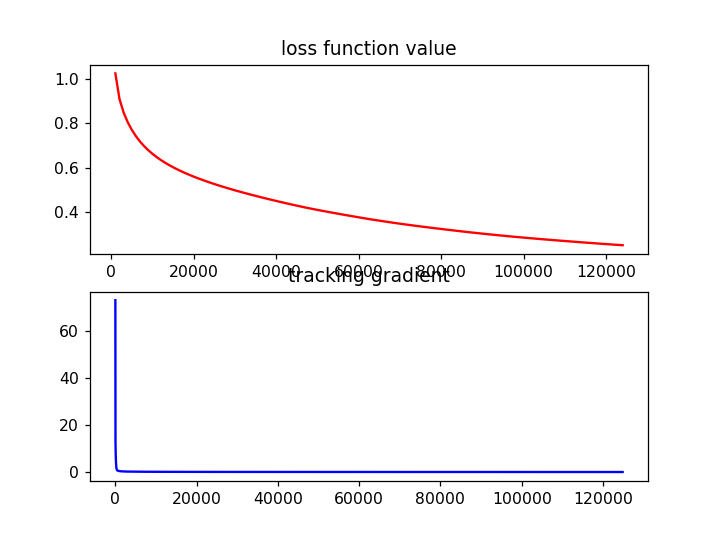

Text(0.5, 1.0, 'tracking gradient')

In [24]:
# w = model.linear.weight.data.numpy()
# b = model.linear.bias.data.numpy()
e=[]
for i in range(124824):
    e.append(i)
# print('w:{},b:{}'.format(w,b))
print(loss_value)
plt.figure()
plt.subplot(2,1,1)
plt.plot(elist,floss,'r')
plt.title('loss function value')
plt.subplot(2,1,2)
plt.plot(e,gradlist,'b')
plt.title('tracking gradient')

In [ ]:
# x_train=x_train.numpy()
# y_new = w@x_train[1,:].T+b
# print(y_new)
# print(y_train[1,:])

In [25]:
N=30
xtest = np.zeros([14,N])
utest= np.zeros([7, N])
x_newtest=np.zeros([14,N])
for i in range(N):
    for j in range(7):
        a1=random.randint(-180,180)#angule range(-pi,pi)
        b1=random.uniform(-10, 10)#velocity range
        c1=random.randint(-30,30)#torque range (-200,200)
        xtest[j,i]=math.radians(a1/math.pi)
        xtest[j+7,i]=b1
        utest[j,i]=c1
# print(x)
# print(u)
for i in range(N):
    x_newtest[:,i]=simulate_system(xtest[:,i], utest[:,i])
# x_newtest is from pybullet simulation which is the ture value

xtrain_test = np.concatenate((xtest, utest),axis=0)
xtrain_test = xtrain_test.astype(np.float32)
ytrain_test=np.zeros([14,N])
for i in range(N):
    xt = torch.from_numpy(xtrain_test[:,i].T)
    yt=model(xt)
    yt=yt.detach().numpy()
    ytrain_test[:,i] = yt
#     ytrain_test[:,i] = w@xtrain_test[:,i].T+b
#ytrain_test is the result from prediction model.
print(ytrain_test)

[[-7.47457385e-01 -9.68119144e-01 -2.88119316e-01 -6.43630922e-01
  -4.11201119e-01 -6.64550483e-01 -4.95933115e-01 -4.69369769e-01
   7.88615108e-01 -3.04202080e-01  4.09475267e-01 -6.23608470e-01
   1.84090257e-01  2.50804186e-01  5.86728811e-01 -7.29506493e-01
   3.17753196e-01  7.68731058e-01  3.87143254e-01 -3.44663024e-01
   2.93934271e-02 -3.10025156e-01  3.08593631e-01  3.42758745e-03
   6.05809614e-02 -4.81685460e-01 -1.31330565e-02  3.51048589e-01
  -7.57236958e-01 -6.50754035e-01]
 [ 4.18296993e-01  5.43822162e-02 -2.46426210e-01  7.59587884e-01
  -6.67283058e-01  3.12257588e-01 -3.04332972e-01  6.47728562e-01
   2.66901374e-01 -2.33881310e-01  8.22334766e-01  1.38864174e-01
   9.05245900e-01 -1.10546574e-01  3.81360888e-01 -3.30282599e-01
  -1.30012799e-02  8.07817459e-01 -5.49817920e-01  8.03730667e-01
   3.62404466e-01  1.40344039e-01  2.64790177e-01  2.30153456e-01
   2.42384449e-01  1.07141888e+00 -4.77662027e-01 -2.07154199e-01
   1.73357144e-01  5.45488238e-01]
 [-2.0

[3.283751151045728, 4.247729896261453, 4.334014107812472, 3.8609779109371307, 2.6455965082563595, 3.728965890945211, 3.896946466329919, 3.2756848777061647, 4.75304270852086, 5.184064043360099, 2.828433400576783, 6.0360324833888415, 4.551004887009333, 3.0312559534595866, 1.791362952345178, 2.5225133856439075, 3.907497491618993, 2.0607756636892285, 2.732521415991938, 1.8902879309355942, 1.595392330811419, 2.609898955553355, 2.804329647282405, 3.373072932477052, 2.410178001794309, 3.3950535578858614, 2.502127687918948, 2.4917801920699105, 6.0025834696330636, 2.490629613321399]


<IPython.core.display.Javascript object>


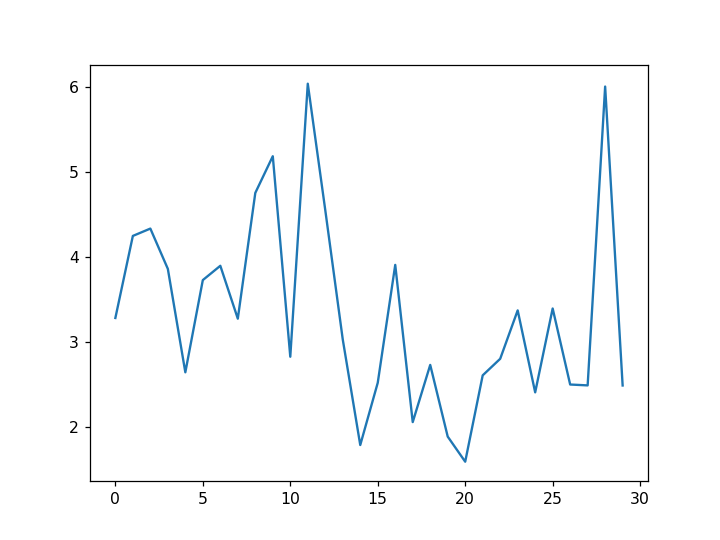

In [26]:
n= [i for i in range(N)]
y_error=np.zeros([14,N])
norm_y=[]
for i in range(N):
    y_error[:,i]=x_newtest[:,i]-ytrain_test[:,i]
    error=np.linalg.norm(y_error[:,i])
    norm_y.append(error)
print(norm_y)
plt.figure()
plt.plot(n,norm_y)

<IPython.core.display.Javascript object>


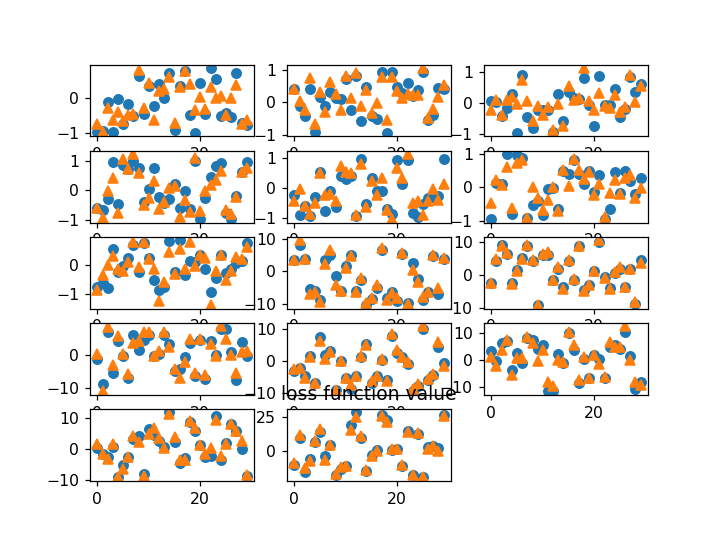

Text(0.5, 1.0, 'loss function value')

In [27]:

plt.figure()
plt.subplot(5,3,1)
plt.plot(n,x_newtest[0,:],'o',n,ytrain_test[0,:],'^')
plt.subplot(5,3,2)
plt.plot(n,x_newtest[1,:],'o',n,ytrain_test[1,:],'^')
plt.subplot(5,3,3)
plt.plot(n,x_newtest[2,:],'o',n,ytrain_test[2,:],'^')
plt.subplot(5,3,4)
plt.plot(n,x_newtest[3,:],'o',n,ytrain_test[3,:],'^')
plt.subplot(5,3,5)
plt.plot(n,x_newtest[4,:],'o',n,ytrain_test[4,:],'^')
plt.subplot(5,3,6)
plt.plot(n,x_newtest[5,:],'o',n,ytrain_test[5,:],'^')
plt.subplot(5,3,7)
plt.plot(n,x_newtest[6,:],'o',n,ytrain_test[6,:],'^')
plt.subplot(5,3,8)
plt.plot(n,x_newtest[7,:],'o',n,ytrain_test[7,:],'^')
plt.subplot(5,3,9)
plt.plot(n,x_newtest[8,:],'o',n,ytrain_test[8,:],'^')
plt.subplot(5,3,10)
plt.plot(n,x_newtest[9,:],'o',n,ytrain_test[9,:],'^')
plt.subplot(5,3,11)
plt.plot(n,x_newtest[10,:],'o',n,ytrain_test[10,:],'^')
plt.subplot(5,3,12)
plt.plot(n,x_newtest[11,:],'o',n,ytrain_test[11,:],'^')
plt.subplot(5,3,13)
plt.plot(n,x_newtest[12,:],'o',n,ytrain_test[12,:],'^')
plt.subplot(5,3,14)
plt.plot(n,x_newtest[13,:],'o',n,ytrain_test[13,:],'^')
plt.title('loss function value')

In [28]:
for m in range(N):
    for i in range(7):
        p.resetJointState(robotId,i,x_newtest[i,m],targetVelocity = x_newtest[i+7,m])
    time.sleep(1./10.)

In [125]:
for m in range(N):
    for i in range(7):
        p.resetJointState(robotId,i,ytrain_test[i,m],targetVelocity = ytrain_test[i+7,m])
    time.sleep(1./10.)

In [15]:
p.disconnect()

In [93]:
# x_test = np.array([4.33333333e-01,  3.72222222e-01,  1.00000000e+00,  6.33333333e-01,
#    7.77777778e-01,  5.50000000e-01,  8.77777778e-01,  5.61716944e+00,
#    4.94226108e-01,  7.71834766e+00,  3.36154878e+00, -7.54252866e+00,
#   -4.02101231e+00, -3.41661910e+00,  3.00000000e+00, -1.80000000e+01,
#    2.80000000e+01,  7.00000000e+00, -2.60000000e+01,  1.00000000e+01,
#    1.40000000e+01])
# y_test = w@x_test.T+b
# u_test = x_test[14::]
# # print(u_test)
# yy = simulate_system(x_test, u_test)
# print(yy)
# print(y_test)

[  3. -18.  28.   7. -26.  10.  14.]
[  0.45662485   0.37251037   1.03471971   0.64772252   0.72732039
   0.53907829   0.92093734   5.5899647    0.06915529   8.33272973
   3.45340603 -12.10977284  -2.62121083  10.35829541]
[  0.45385811   0.37345157   1.0436823    0.64408953   0.71317111
   0.52967566   0.92743128   4.97856798   0.35430945  10.62898456
   2.67411728 -15.40639208  -4.80739822  12.05863793]


In [55]:
# for i in range(7):
#         p.resetJointState(robotId,i,yy[i],targetVelocity = yy[i+7])
        

In [56]:
# for i in range(7):
#         p.resetJointState(robotId,i,y_test[i],targetVelocity = y_test[i+7])